In [2]:
# Generic Setup
from pathlib import Path
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [25]:
# File Setup
data_folder = Path('/Users/andreakeane/Documents/DataScience/GridCure_Problems/EV_files/')

# Test Data
file_evtest = data_folder / "EV_test.csv"
test = pd.read_csv(file_evtest, index_col='House ID')

# Train Data
file_evtrain = data_folder / "EV_train.csv"
train = pd.read_csv(file_evtrain, index_col='House ID')

# Train Labels
file_evlabels = data_folder / "EV_train_labels.csv"
labels = pd.read_csv(file_evlabels, index_col='House ID')

print("Data Frame Shapes")
print("Test: {}".format(test.shape))
print("Train: {}".format(train.shape))
print("Labels: {}".format(labels.shape))

Data Frame Shapes
Test: (699, 2880)
Train: (1590, 2880)
Labels: (1590, 2880)


Questions to ask: 
1. Which and how many features am I taking into account to detect outliers ? (univariate / multivariate)  
2. Can I assume a distribution(s) of values for my selected features? (parametric / non-parametric)  


Some of the most popular methods for outlier detection are:
  * Z-Score or Extreme Value Analysis (parametric)  
  * Probabilistic and Statistical Modeling (parametric)  
  * Linear Regression Models (PCA, LMS)  
  * Proximity Based Models (non-parametric)  
  * Information Theory Models  
  * High Dimensional Outlier Detection Methods (high dimensional sparse data)  

https://towardsdatascience.com/a-brief-overview-of-outlier-detection-techniques-1e0b2c19e561

DBScan  
https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py 



In [52]:
X = train.copy(deep=True)

from collections import namedtuple
df_summary = namedtuple('df_summary', 
                        ['rows', 'cols', 'idx_list'])

# Drop NA-containing rows from X
before = df_summary(X.shape[0], X.shape[1], X.index.tolist())
X = X.dropna()
after = df_summary(X.shape[0], X.shape[1], X.index.tolist())
print("{} Rows were dropped for NA reasons.".format(before.rows - after.rows))

# Scale the features between -1 and 1
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)                                    
X_scaled = scaler.transform(X)

4 Rows were dropped for NA reasons.


## DBScan 
https://scikit-learn.org/stable/modules/clustering.html#dbscan  
https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py  

IMPORTANT NOTE: I tried this and wasn't satisfied with the outcome. Therefore, this is not the final approach I took to classifying outliers. 

There are two parameters to the algorithm, min_samples and eps, which define formally what we mean when we say dense. Higher min_samples or lower eps indicate higher density necessary to form a cluster.

In [60]:
# DBScan 
import numpy as np
from sklearn.cluster import DBSCAN

# #############################################################################
# Compute DBSCAN
for e in [0.5, 1, 2, 3, 5, 7, 10, 20, 50, 80]: 
    db = DBSCAN(eps=e, min_samples=20).fit(X_scaled)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("{}, {}, {}".format(e, n_clusters_, n_noise_))

# print('Estimated number of clusters: {}'.format(n_clusters_))
# print('Estimated number of noise points: %d' % n_noise_)


0.5, 0, 1586
1, 0, 1586
2, 0, 1586
3, 0, 1586
5, 1, 1510
7, 1, 1290
10, 1, 891
20, 1, 145
50, 1, 39
80, 1, 22


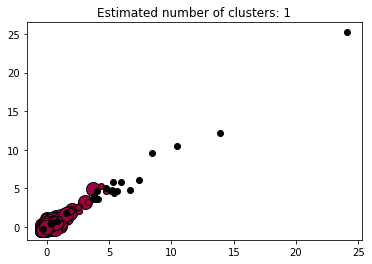

In [62]:
# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_scaled[class_member_mask & core_samples_mask]
    thing_1 = xy[:, 0]
    thing_2 = xy[:, 1]
    plt.plot(thing_1, thing_2, 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

    xy = X_scaled[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()